# Capstone Project - The Battle of Neighborhoods

#### Introduction:

To determine which Neighborhood has the best Grocery store in Downtown Toronto. Based on the output from foursquare, user can easily determine which Grocery Store is best to visit based on feedback.

#### Data Requirements:
For this assignment, I will be utilizing the Foursquare API to pull the following location data on Grocery Stores in Downtown Toronto.

- Venue Name
- Venue ID
- Venue Location
- Venue Category
- Total Likes

Importing all necessary Libraries

In [1]:
!conda install -c conda-forge geopy -y
!pip install geocoder
!pip install folium
!pip install beautifulsoup4
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

Solving environment: done

# All requested packages already installed.

All Required Libraries Imported!


In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data,"html5lib")

In [3]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
toronto.head()

,Postalcode,Borough,Neighborhood
0,0,0,0
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [7]:
df = toronto.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df=df[1:]
df=df.reset_index(drop=True)

In [11]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
# Retrieving Postal Code Co-ordinates
postal_codes = df['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


Lets segment and cluster only the neighborhoods in Downtown Toronto. So let's slice the original dataframe and create a new dataframe of the Downtown Toronto data.

In [12]:
dt_data = df[df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
dt_data

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587
4,M5E,Downtown Toronto,Berczy Park,43.64536,-79.37306
5,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493
6,M6G,Downtown Toronto,Christie,43.66869,-79.42071
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.64970,-79.38258
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.64285,-79.38076
9,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.64710,-79.38153


Now lets get the geographic co-ordinates of Downtown Toronto

In [13]:
address = 'Downtown Toronto, Toronto'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081164513409.


Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # your Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET:1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Id',           
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
dt_venues = getNearbyVenues(names=dt_data['Neighborhood'],
                                   latitudes=dt_data['Latitude'],
                                   longitudes=dt_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [32]:
print(dt_venues.shape)
dt_venues.head()

(1214, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65512,-79.36264,Roselle Desserts,54ea41ad498e9a11e9e13308,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65512,-79.36264,Tandem Coffee,53b8466a498e83df908c3f21,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65512,-79.36264,Figs Breakfast & Lunch,4af59046f964a520e0f921e3,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.65512,-79.36264,Souvlaki Express,4bc39c914cdfc9b6f29c9721,43.655584,-79.364438,Greek Restaurant
4,"Regent Park, Harbourfront",43.65512,-79.36264,The Yoga Lounge,4b58dd55f964a5208f6f28e3,43.655515,-79.364955,Yoga Studio


In [33]:
dt_venues = dt_venues[dt_venues['Venue Category'] == 'Grocery Store'].reset_index(drop=True)
dt_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,43.64536,-79.37306,Loblaws,4adb6a84f964a520332721e3,43.645427,-79.369789,Grocery Store
1,Christie,43.66869,-79.42071,Fiesta Farms,4adcfd7cf964a5203e6321e3,43.668471,-79.420485,Grocery Store
2,Christie,43.66869,-79.42071,Loblaws,4aee0faef964a520b1d121e3,43.671657,-79.421364,Grocery Store
3,"Harbourfront East, Union Station, Toronto Islands",43.64285,-79.38076,Sobeys Urban Fresh Queens Quay,4ba3d4c8f964a5204b6438e3,43.638769,-79.380756,Grocery Store
4,"University of Toronto, Harbord",43.66311,-79.40180,Noah's Natural Food,4ae5d2bcf964a5204fa221e3,43.666915,-79.403458,Grocery Store
5,"Kensington Market, Chinatown, Grange Park",43.65351,-79.39722,金城超級市場 Lucky Moose Food Mart,4adb87b0f964a520ad2821e3,43.653651,-79.394413,Grocery Store
6,"Kensington Market, Chinatown, Grange Park",43.65351,-79.39722,Perola Supermarket,4b804b28f964a5200f6530e3,43.654894,-79.402146,Grocery Store
7,"CN Tower, King and Spadina, Railway Lands, Har...",43.64082,-79.39818,Loblaws,5f5ba8f9947f2a1bd1d03ff7,43.636906,-79.399311,Grocery Store
8,"CN Tower, King and Spadina, Railway Lands, Har...",43.64082,-79.39818,Sobeys Urban Fresh Spadina,4adf35b4f964a520547821e3,43.640528,-79.394379,Grocery Store
9,"St. James Town, Cabbagetown",43.66788,-79.36649,Matt's No Frills,4b4bd6c4f964a5202da926e3,43.663515,-79.367166,Grocery Store


In [35]:
venue_id_list = dt_venues['Venue Id'].tolist()
venue_id_list

['4adb6a84f964a520332721e3',
 '4adcfd7cf964a5203e6321e3',
 '4aee0faef964a520b1d121e3',
 '4ba3d4c8f964a5204b6438e3',
 '4ae5d2bcf964a5204fa221e3',
 '4adb87b0f964a520ad2821e3',
 '4b804b28f964a5200f6530e3',
 '5f5ba8f9947f2a1bd1d03ff7',
 '4adf35b4f964a520547821e3',
 '4b4bd6c4f964a5202da926e3',
 '58a5b19bbbec660f5161aadd',
 '4d5837c71270236a8e3a9359']

In [54]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[132, 89, 59, 30, 6, 52, 21, 1, 87, 17, 16, 15]


In [55]:
dt_venues['Total likes'] = like_list
dt_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category,Total likes,Total likes_cat,Feedback
0,Berczy Park,43.64536,-79.37306,Loblaws,4adb6a84f964a520332721e3,43.645427,-79.369789,Grocery Store,132,Highly Recommended,Highly Recommended
1,Christie,43.66869,-79.42071,Fiesta Farms,4adcfd7cf964a5203e6321e3,43.668471,-79.420485,Grocery Store,89,Highly Recommended,Highly Recommended
2,Christie,43.66869,-79.42071,Loblaws,4aee0faef964a520b1d121e3,43.671657,-79.421364,Grocery Store,59,Average,Average
3,"Harbourfront East, Union Station, Toronto Islands",43.64285,-79.38076,Sobeys Urban Fresh Queens Quay,4ba3d4c8f964a5204b6438e3,43.638769,-79.380756,Grocery Store,30,Average,Average
4,"University of Toronto, Harbord",43.66311,-79.40180,Noah's Natural Food,4ae5d2bcf964a5204fa221e3,43.666915,-79.403458,Grocery Store,6,Not recommended,Not Recommended


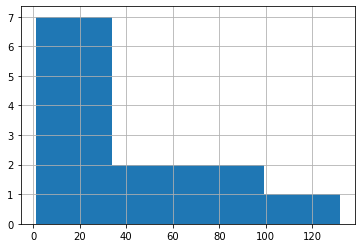

In [40]:
# let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
dt_venues['Total likes'].hist(bins=4)
plt.show()

In [42]:
# what are the bins we want to use?

print(np.percentile(dt_venues['Total likes'], 25))
print(np.percentile(dt_venues['Total likes'], 50))
print(np.percentile(dt_venues['Total likes'], 75))

15.75
25.5
66.0


In [56]:
# now we have our bin values so let's set them to the appropriate values
# less than 15, 15-25, 25-66, 66>
# poor, below avg, abv avg, great

poor = dt_venues['Total likes']<=15
below_avg = dt_venues[(dt_venues['Total likes']>15) & (dt_venues['Total likes']<=25)]
abv_avg = dt_venues[(dt_venues['Total likes']>25) & (dt_venues['Total likes']<=66)]
great = dt_venues['Total likes']>66

In [60]:
# let's set up a function that will re-categorize Grocery Stores based on likes

def conditions(s):
    if s['Total likes']<=15:
        return 'Not Recommended'
    if s['Total likes']<=25:
        return 'Below Average'
    if s['Total likes']<=66:
        return 'Average'
    if s['Total likes']>66:
        return 'Highly Recommended'

dt_venues['Feedback']=dt_venues.apply(conditions, axis=1)

In [86]:
dt_venues1=dt_venues
dt_venues1

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category,Total likes,Total likes_cat,Feedback
0,0,Berczy Park,43.64536,-79.37306,Loblaws,4adb6a84f964a520332721e3,43.645427,-79.369789,Grocery Store,132,Highly Recommended,Highly Recommended
1,0,Christie,43.66869,-79.42071,Fiesta Farms,4adcfd7cf964a5203e6321e3,43.668471,-79.420485,Grocery Store,89,Highly Recommended,Highly Recommended
2,0,Christie,43.66869,-79.42071,Loblaws,4aee0faef964a520b1d121e3,43.671657,-79.421364,Grocery Store,59,Average,Average
3,0,"Harbourfront East, Union Station, Toronto Islands",43.64285,-79.38076,Sobeys Urban Fresh Queens Quay,4ba3d4c8f964a5204b6438e3,43.638769,-79.380756,Grocery Store,30,Average,Average
4,2,"University of Toronto, Harbord",43.66311,-79.40180,Noah's Natural Food,4ae5d2bcf964a5204fa221e3,43.666915,-79.403458,Grocery Store,6,Not recommended,Not Recommended
5,0,"Kensington Market, Chinatown, Grange Park",43.65351,-79.39722,金城超級市場 Lucky Moose Food Mart,4adb87b0f964a520ad2821e3,43.653651,-79.394413,Grocery Store,52,Average,Average
6,1,"Kensington Market, Chinatown, Grange Park",43.65351,-79.39722,Perola Supermarket,4b804b28f964a5200f6530e3,43.654894,-79.402146,Grocery Store,21,Below Average,Below Average
7,2,"CN Tower, King and Spadina, Railway Lands, Har...",43.64082,-79.39818,Loblaws,5f5ba8f9947f2a1bd1d03ff7,43.636906,-79.399311,Grocery Store,1,Not recommended,Not Recommended
8,0,"CN Tower, King and Spadina, Railway Lands, Har...",43.64082,-79.39818,Sobeys Urban Fresh Spadina,4adf35b4f964a520547821e3,43.640528,-79.394379,Grocery Store,87,Highly Recommended,Highly Recommended
9,1,"St. James Town, Cabbagetown",43.66788,-79.36649,Matt's No Frills,4b4bd6c4f964a5202da926e3,43.663515,-79.367166,Grocery Store,17,Below Average,Below Average


In [87]:
# one hot encoding
dt_onehot = pd.get_dummies(dt_venues1[['Total likes_cat']], prefix="", prefix_sep="")

In [91]:
# set number of clusters
kclusters = 4

# add neighborhood column back to dataframe
dt_onehot['Neighborhood'] = dt_venues1['Neighborhood'] 

dt_clustering = dt_onehot.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dt_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 0, 0, 2, 0, 1, 2, 3, 1], dtype=int32)

In [92]:
# add clustering labels
dt_venues.insert(0, 'Cluster Labels', kmeans.labels_)

dt_merged = dt_data


dt_merged = dt_merged.join(dt_venues.set_index('Neighborhood'), on='Neighborhood')
dt_merged=dt_merged.dropna()
dt_merged.head() # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

Lets Visualize Clusters

In [94]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dt_merged['Latitude'], dt_merged['Longitude'], dt_merged['Neighborhood'], dt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster# 1

In [95]:
dt_merged.loc[dt_merged['Cluster Labels'] == 0, dt_merged.columns[[1] + list(range(5, dt_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category,Total likes,Total likes_cat,Feedback
4,Downtown Toronto,0.0,43.64536,-79.37306,Loblaws,4adb6a84f964a520332721e3,43.645427,-79.369789,Grocery Store,132.0,Highly Recommended,Highly Recommended
6,Downtown Toronto,0.0,43.66869,-79.42071,Fiesta Farms,4adcfd7cf964a5203e6321e3,43.668471,-79.420485,Grocery Store,89.0,Highly Recommended,Highly Recommended
6,Downtown Toronto,0.0,43.66869,-79.42071,Loblaws,4aee0faef964a520b1d121e3,43.671657,-79.421364,Grocery Store,59.0,Average,Average
8,Downtown Toronto,0.0,43.64285,-79.38076,Sobeys Urban Fresh Queens Quay,4ba3d4c8f964a5204b6438e3,43.638769,-79.380756,Grocery Store,30.0,Average,Average
12,Downtown Toronto,0.0,43.65351,-79.39722,金城超級市場 Lucky Moose Food Mart,4adb87b0f964a520ad2821e3,43.653651,-79.394413,Grocery Store,52.0,Average,Average
13,Downtown Toronto,0.0,43.64082,-79.39818,Sobeys Urban Fresh Spadina,4adf35b4f964a520547821e3,43.640528,-79.394379,Grocery Store,87.0,Highly Recommended,Highly Recommended


#### Cluster# 2

In [97]:
dt_merged.loc[dt_merged['Cluster Labels'] == 1, dt_merged.columns[[1] + list(range(5, dt_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category,Total likes,Total likes_cat,Feedback
12,Downtown Toronto,1.0,43.65351,-79.39722,Perola Supermarket,4b804b28f964a5200f6530e3,43.654894,-79.402146,Grocery Store,21.0,Below Average,Below Average
16,Downtown Toronto,1.0,43.66788,-79.36649,Matt's No Frills,4b4bd6c4f964a5202da926e3,43.663515,-79.367166,Grocery Store,17.0,Below Average,Below Average
18,Downtown Toronto,1.0,43.66659,-79.38133,H Mart,58a5b19bbbec660f5161aadd,43.669332,-79.386257,Grocery Store,16.0,Below Average,Below Average


#### Cluster# 3

In [98]:
dt_merged.loc[dt_merged['Cluster Labels'] == 2, dt_merged.columns[[1] + list(range(5, dt_merged.shape[1]))]]

,Borough,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category,Total likes,Total likes_cat,Feedback
11,Downtown Toronto,2.0,43.66311,-79.40180,Noah's Natural Food,4ae5d2bcf964a5204fa221e3,43.666915,-79.403458,Grocery Store,6.0,Not recommended,Not Recommended
13,Downtown Toronto,2.0,43.64082,-79.39818,Loblaws,5f5ba8f9947f2a1bd1d03ff7,43.636906,-79.399311,Grocery Store,1.0,Not recommended,Not Recommended
18,Downtown Toronto,2.0,43.66659,-79.38133,Rabba Fine Foods,4d5837c71270236a8e3a9359,43.666502,-79.376092,Grocery Store,15.0,Not recommended,Not Recommended


#### Results & Discussion:

So we made 3 clusters on the feedback of Grocery Stores & user can select the best Grocery store in Downtown Toronto based on the feedback. The results would have been much better if 4 clusters were made.

#### Conclusion:

Overall a good application of the key concepts of data science & machine learning after completing this Capstone Project.